In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns

from sklearn.metrics import r2_score
import seaborn as sns
from pprint import pprint


import os
import datetime
from math import sqrt

import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Dropout, Flatten
from tensorflow.keras import  regularizers

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
import tensorflow.keras.backend as K
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers

from sklearn.metrics import mean_squared_error


#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

# pd.set_option('max_columns', 50)

***import data***

In [2]:
#import data
df = pd.read_csv("../FRAME SIZE AWARE prediction/H264-data/nbc_news_G16B3_QP48.csv",
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [3]:

df.sort_values('arrival_time', inplace=True)
df.drop(['decoded_frame'], axis=1, inplace=True)
df.drop(['x','y','z'], axis=1, inplace=True)
df.head()

,arrival_time,video_frame,frame_size
0,0.00000,I,1976
2,33.33333,B,128
3,66.66667,B,168
4,100.00000,B,168
1,133.33333,P,120


In [4]:
# corr = df.corr()
# pprint(corr['frame_size'])
# sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [5]:
df.describe()

,arrival_time,frame_size
count,4.952100e+04,49521.000000
mean,8.253333e+05,1084.113972
std,4.765209e+05,2237.753489
min,0.000000e+00,120.000000
25%,4.126667e+05,152.000000
50%,8.253333e+05,200.000000
75%,1.238000e+06,792.000000
max,1.650667e+06,28216.000000


In [6]:
df.dtypes

arrival_time    float64
video_frame      object
frame_size        int64
dtype: object

In [7]:
print(df.isnull().sum())
df = df.replace(0, np.nan)
print(df.isnull().sum())
df = df.interpolate(method='linear', axis=0).ffill().bfill()
df.isnull().sum() 

arrival_time    0
video_frame     0
frame_size      0
dtype: int64
arrival_time    1
video_frame     0
frame_size      0
dtype: int64


arrival_time    0
video_frame     0
frame_size      0
dtype: int64

In [8]:
# #Check for missing values
# print("total number of rows : {0}".format(len(data)))
# print("number of rows missing traffic: {0}".format(len(data.loc[data['frame_size'] == 0])))
# print(data.head())

# #Fill missing values
# data = data.replace(0, np.nan) # first replace 0 values with nan values, otherwise fill function doesnot work
# #daily_data.fillna(method= 'bfill', inplace=True) # fill using backward fill pandas function
# data.interpolate(method= 'linear', inplace=True)


# #Check how many other missing(zero) values
# print("total number of rows : {0}".format(len(data)))
# print("number of rows missing traffic: {0}".format(len(data.loc[data['frame_size'] == 0])))
# print(data.head())

In [9]:
minimum = []
maximum = []
minimum.append(df['frame_size'].min())
maximum.append(df['frame_size'].max())
# minimum.append(df['Outdoor'].min())
# maximum.append(df['Outdoor'].max())
# minimum.append(df['Hour'].min())
# maximum.append(df['Hour'].max())


scaler = MinMaxScaler(feature_range=(0, 1))
df[['arrival_time', 'frame_size']] = scaler.fit_transform(df[['arrival_time', 'frame_size']])
# df[['arrival_time', 'frame_size','x','y','z']] = scaler.fit_transform(df[['arrival_time', 'frame_size','x','y','z']])
# df[['frame_size']] = scaler.fit_transform(df[['Load']])
# df = scaler.fit_transform(df)

df.head()

,arrival_time,video_frame,frame_size
0,0.000000,I,0.066059
2,0.000000,B,0.000285
3,0.000020,B,0.001708
4,0.000040,B,0.001708
1,0.000061,P,0.000000


In [10]:
length_of_col = len(df.columns)

look_back = 16
df1 = df.copy()
df1.drop(['video_frame', 'arrival_time'],axis=1,inplace=True)
# df1.drop(['Temperature','Hour','Weekday','Humidity'],axis=1,inplace=True)

# df1.drop(['Time'],axis=1,inplace=True)

for i in range(1,look_back+1):
    if i%4 == 0:
        SHIFT = i
        df_copy = df1.copy()
        df_copy.rename(columns={'frame_size':'frame_size_(t-{})'.format(SHIFT)}, inplace = True)

    #     df_copy.rename(columns={'frame_size':'frame_size_(t-{})'.format(SHIFT),\
    #                            'x':'x_(t-{})'.format(SHIFT),\
    #                            'y':'y_(t-{})'.format(SHIFT),\
    #                            'z':'z_(t-{})'.format(SHIFT)}, inplace = True)
        df = pd.concat([df,df_copy.shift(SHIFT)],axis = 1)
df.dropna(axis = 0, inplace=True)
df = df.reset_index(drop=True)
df.head()

,arrival_time,video_frame,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16)
0,0.000303,I,0.105353,0.002563,0.000285,0.000000,0.066059
1,0.000323,B,0.007688,0.007688,0.002278,0.002278,0.000285
2,0.000343,B,0.006549,0.008827,0.002278,0.002278,0.001708
3,0.000363,B,0.005695,0.009112,0.002278,0.002278,0.001708
4,0.000384,P,0.056093,0.105353,0.002563,0.000285,0.000000


arrival_time         0.022444
frame_size           1.000000
frame_size_(t-4)     0.297026
frame_size_(t-8)     0.275135
frame_size_(t-12)    0.280250
frame_size_(t-16)    0.914766
Name: frame_size, dtype: float64


<AxesSubplot:>

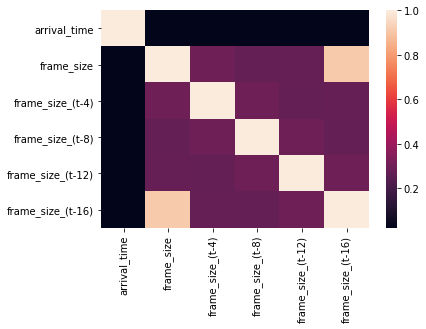

In [11]:
corr = df.corr()
pprint(corr['frame_size'])
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

***Define parameters***

In [12]:
df = pd.get_dummies(df, columns = ['video_frame'])
df.head()

,arrival_time,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
0,0.000303,0.105353,0.002563,0.000285,0.000000,0.066059,0,1,0
1,0.000323,0.007688,0.007688,0.002278,0.002278,0.000285,1,0,0
2,0.000343,0.006549,0.008827,0.002278,0.002278,0.001708,1,0,0
3,0.000363,0.005695,0.009112,0.002278,0.002278,0.001708,1,0,0
4,0.000384,0.056093,0.105353,0.002563,0.000285,0.000000,0,0,1


In [13]:
df.columns

Index(['arrival_time', 'frame_size', 'frame_size_(t-4)', 'frame_size_(t-8)',
       'frame_size_(t-12)', 'frame_size_(t-16)', 'video_frame_B',
       'video_frame_I', 'video_frame_P'],
      dtype='object')

In [14]:
df.drop(['arrival_time'], axis=1, inplace=True)
df.head()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
0,0.105353,0.002563,0.000285,0.000000,0.066059,0,1,0
1,0.007688,0.007688,0.002278,0.002278,0.000285,1,0,0
2,0.006549,0.008827,0.002278,0.002278,0.001708,1,0,0
3,0.005695,0.009112,0.002278,0.002278,0.001708,1,0,0
4,0.056093,0.105353,0.002563,0.000285,0.000000,0,0,1


In [15]:
look_back = 1
length_of_col = len(df.columns)-1

In [16]:
X = np.array(df[df.columns[1:]].to_numpy())
y = np.array(df["frame_size"])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
temp1 = int(0.8*len(X))-4
temp2 = int(0.1*len(X))-6

X_train = X[:temp1]
X_val = X[temp1:temp1+temp2]
X_test = X[temp1+temp2:]

y_train = y[:temp1]
y_val = y[temp1:temp1+temp2]
y_test = y[temp1+temp2:]


print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(39600, 7) (4944, 7) (4961, 7)
(39600,) (4944,) (4961,)


In [17]:
X_train = X_train.reshape((X_train.shape[0], look_back, length_of_col))
X_test = X_test.reshape((X_test.shape[0], look_back, length_of_col))
X_val = X_val.reshape((X_val.shape[0], look_back, length_of_col))

print(X_train.shape, X_val.shape, X_test.shape)

# y_train = y_train.reshape((X_train.shape[0], look_back, 1))
# y_test = y_test.reshape((X_test.shape[0], look_back, 1))
# y_val = y_val.reshape((X_val.shape[0], look_back, 1))

# print(y_train.shape, y_val.shape, y_test.shape)


(39600, 1, 7) (4944, 1, 7) (4961, 1, 7)


# LSTM Model

In [18]:
epoch = 400
batch_size = 50
lr = 0.005

model = Sequential()

model.add((LSTM(units=32, return_sequences=True, input_shape=(look_back, X_train.shape[2]), activation='relu')))
# model.add(SeqSelfAttention(attention_activation='relu'))
# model.add((LSTM(units=20, return_sequences=True, activation='relu')))
model.add((LSTM(units=16, return_sequences=True, activation='relu')))
# model.add((LSTM(units=5, return_sequences=True, activation='relu')))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units = 1,activation='sigmoid'))

adam = tf.keras.optimizers.Adam(lr=lr)
model.compile(loss = 'mean_squared_error', optimizer = adam)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epoch, batch_size=batch_size,verbose=1, shuffle = False)
model.summary()


Epoch 1/400
792/792 [==============================] - 4s 3ms/step - loss: 0.0338 - val_loss: 0.0014
Epoch 2/400
792/792 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/400
792/792 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/400
792/792 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 9.7280e-04
Epoch 5/400
792/792 [==============================] - 1s 1ms/step - loss: 8.8183e-04 - val_loss: 8.3203e-04
Epoch 6/400
792/792 [==============================] - 1s 1ms/step - loss: 7.1842e-04 - val_loss: 7.7676e-04
Epoch 7/400
792/792 [==============================] - 1s 1ms/step - loss: 6.7187e-04 - val_loss: 7.3956e-04
Epoch 8/400
792/792 [==============================] - 1s 1ms/step - loss: 6.6701e-04 - val_loss: 7.2149e-04
Epoch 9/400
792/792 [==============================] - 1s 1ms/step - loss: 6.5149e-04 - val_loss: 7.0689e-04
Epoch 10/400
792/792 [=========================

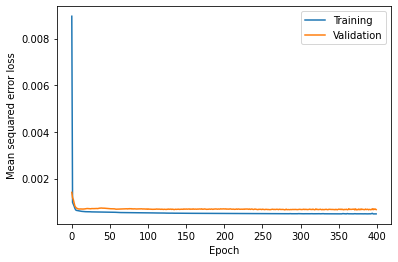

In [19]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model Loss')
plt.ylabel('Mean sequared error loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [20]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = trainPredict*(maximum[0]-minimum[0]) + minimum[0]
y_train = y_train*(maximum[0]-minimum[0]) + minimum[0]

testPredict = testPredict*(maximum[0]-minimum[0]) + minimum[0]
y_test = y_test*(maximum[0]-minimum[0]) + minimum[0]


In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return (np.sum(np.abs((y_pred-y_true) / y_true))/len(y_true))*100
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def cv_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.sqrt(np.sum(np.square(y_pred-y_true))/(len(y_true)-1))/np.mean(y_true))*100

In [22]:
trainPredict = trainPredict.reshape(trainPredict.shape[0])
testPredict = testPredict.reshape(testPredict.shape[0])

testPredict.shape

(4961,)

In [23]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

y_test.shape

(4961,)

In [24]:
# trainScore = round(math.sqrt(mean_squared_error(y_train, trainPredict[:,])),2)
# testScore = round(math.sqrt(mean_squared_error(y_test, testPredict[:,])),2)

mape_score_train = round(mean_absolute_percentage_error(y_train, trainPredict[:,]),2)
mape_score_test = round(mean_absolute_percentage_error(y_test, testPredict[:,]),2)

cv_score_train = round(cv_error(y_train, trainPredict[:,]),2)
cv_score_test = round(cv_error(y_test, testPredict[:,]),2)

train_pearson = round(pearsonr(trainPredict, y_train)[0],3)
test_pearson = round(pearsonr(testPredict, y_test)[0],3)


In [25]:
# print('Train Score: %.2f RMSE' % (trainScore))
# print('Train Score: %.2f MAPE' % (mape_score_train))
# print('Train Score: %.2f CV' % (cv_score_train))
# print('Pearson Score: %.3f' %(train_pearson))

print()

# print('Test Score: %.2f RMSE' % (testScore))
print('Test Score: %.2f MAPE' % (mape_score_test))
print('Test Score: %.2f CV' % (cv_score_test))
print('Pearson Score: %.3f' %(test_pearson))


Test Score: 44.49 MAPE
Test Score: 76.37 CV
Pearson Score: 0.941


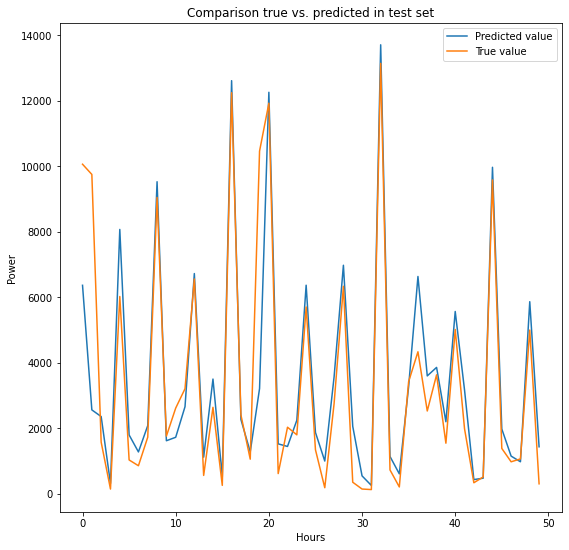

In [26]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=[9,9]);
temp = 100
ax1.plot(testPredict[::temp],label="Predicted value")
ax1.plot(y_test[::temp],label="True value")
plt.xlabel("Hours")
plt.ylabel("Power")
plt.title("Comparison true vs. predicted in test set")
plt.legend(loc='upper right')

plt.show()
# fig.savefig('Alexandria_onehour_LSTM_with_epoch_{}_with_{}_steps.png'.format(epoch,look_back))


In [27]:
model.save("lstm.h5")


In [28]:
df_test = df[temp1+temp2:].copy()
df_test.reset_index(drop=True, inplace=True)
df_test.head()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
0,0.353929,0.032745,0.248007,0.229784,0.385820,0,1,0
1,0.000285,0.000285,0.000854,0.062073,0.003132,1,0,0
2,0.000285,0.000285,0.000854,0.009966,0.036446,1,0,0
3,0.000285,0.000285,0.000854,0.010535,0.122153,1,0,0
4,0.025626,0.353929,0.032745,0.248007,0.229784,0,0,1


In [29]:
df_test['frame_size'] = df_test['frame_size']*(maximum[0]-minimum[0]) + minimum[0]
df_test['frame_size_(t-4)'] = df_test['frame_size_(t-4)']*(maximum[0]-minimum[0]) + minimum[0]
df_test['frame_size_(t-8)'] = df_test['frame_size_(t-8)']*(maximum[0]-minimum[0]) + minimum[0]
df_test['frame_size_(t-12)'] = df_test['frame_size_(t-12)']*(maximum[0]-minimum[0]) + minimum[0]
df_test['frame_size_(t-16)'] = df_test['frame_size_(t-16)']*(maximum[0]-minimum[0]) + minimum[0]
df_test.head()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
0,10064.0,1040.0,7088.0,6576.0,10960.0,0,1,0
1,128.0,128.0,144.0,1864.0,208.0,1,0,0
2,128.0,128.0,144.0,400.0,1144.0,1,0,0
3,128.0,128.0,144.0,416.0,3552.0,1,0,0
4,840.0,10064.0,1040.0,7088.0,6576.0,0,0,1


In [30]:
df_test['predictions'] = testPredict
df_test = df_test.round(2)
df_test.head()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P,predictions
0,10064.0,1040.0,7088.0,6576.0,10960.0,0,1,0,6366.009766
1,128.0,128.0,144.0,1864.0,208.0,1,0,0,144.419998
2,128.0,128.0,144.0,400.0,1144.0,1,0,0,185.710007
3,128.0,128.0,144.0,416.0,3552.0,1,0,0,341.269989
4,840.0,10064.0,1040.0,7088.0,6576.0,0,0,1,578.799988


In [31]:
y.shape

(49505,)

In [32]:
X = X.reshape((X.shape[0], look_back, length_of_col))

Whole_Predict = model.predict(X)
Whole_Predict = Whole_Predict*(maximum[0]-minimum[0]) + minimum[0]
y = y*(maximum[0]-minimum[0]) + minimum[0]


In [33]:
Whole_Predict = Whole_Predict.reshape(Whole_Predict.shape[0])
Whole_Predict.shape

(49505,)

In [34]:
# trainScore = round(math.sqrt(mean_squared_error(y_train, trainPredict[:,])),2)
# testScore = round(math.sqrt(mean_squared_error(y_test, testPredict[:,])),2)

mape_score = round(mean_absolute_percentage_error(Whole_Predict, y),2)
cv_score = round(cv_error(Whole_Predict, y),2)
pearson_score = round(pearsonr(Whole_Predict, y)[0],3)


print('Test Score: %.2f MAPE' % (mape_score))
print('Test Score: %.2f CV' % (cv_score))
print('Pearson Score: %.3f' %(pearson_score))

Test Score: 33.85 MAPE
Test Score: 58.34 CV
Pearson Score: 0.957


In [35]:
df_whole = pd.DataFrame(df)
df_whole.reset_index(drop=True, inplace=True)
df_whole.head()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
0,0.105353,0.002563,0.000285,0.000000,0.066059,0,1,0
1,0.007688,0.007688,0.002278,0.002278,0.000285,1,0,0
2,0.006549,0.008827,0.002278,0.002278,0.001708,1,0,0
3,0.005695,0.009112,0.002278,0.002278,0.001708,1,0,0
4,0.056093,0.105353,0.002563,0.000285,0.000000,0,0,1


In [36]:
df_whole.tail()

,frame_size,frame_size_(t-4),frame_size_(t-8),frame_size_(t-12),frame_size_(t-16),video_frame_B,video_frame_I,video_frame_P
49500,0.019932,0.018508,0.018508,0.236617,0.015091,0,0,1
49501,0.001424,0.000285,0.000285,0.000285,0.001993,1,0,0
49502,0.002563,0.000285,0.000285,0.000285,0.001993,1,0,0
49503,0.002563,0.000285,0.000285,0.000285,0.001993,1,0,0
49504,0.169134,0.019932,0.018508,0.018508,0.236617,0,1,0


In [37]:
df_whole = df.copy()
df_whole.reset_index(drop=True, inplace=True)
df_whole.drop(['frame_size_(t-4)','frame_size_(t-8)','frame_size_(t-12)','frame_size_(t-16)'], axis=1, inplace=True)
df_whole['frame_size'] = df_whole['frame_size']*(maximum[0]-minimum[0]) + minimum[0]
df_whole['predictions'] = Whole_Predict
df_whole = df_whole.round(2)
df_whole.head()

,frame_size,video_frame_B,video_frame_I,video_frame_P,predictions
0,3080.0,0,1,0,3545.260010
1,336.0,1,0,0,283.850006
2,304.0,1,0,0,307.059998
3,280.0,1,0,0,312.390015
4,1696.0,0,0,1,1730.739990


In [38]:
mean_P = df_whole[df_whole['video_frame_P'] == 1]['predictions'].mean().round(2)
max_P  = df_whole[df_whole['video_frame_P'] == 1]['predictions'].max().round(2)

mean_I = df_whole[df_whole['video_frame_I'] == 1]['predictions'].mean().round(2)
max_I  = df_whole[df_whole['video_frame_I'] == 1]['predictions'].max().round(2)

mean_B = df_whole[df_whole['video_frame_B'] == 1]['predictions'].mean().round(2)
max_B  = df_whole[df_whole['video_frame_B'] == 1]['predictions'].max().round(2)


print(mean_P,
max_P,
mean_I,
max_I,
mean_B,
max_B)

1960.44 16698.28 8792.18 28216.0 286.56 3531.9


In [39]:

#Calculate the following token generation rate for each frame type (I, P and B):

#I-frame (token generation of I-frame)
R = max_I / mean_I
R= np.ceil(R)
print('I rate', R)

# P-frame (token generation rate of P-frame)
P = R * mean_P
P = np.ceil(P)
print ('P rate', P)

# B-frame (token generation rate of B-frame)
B = R * mean_B
B = np.ceil(B)
print('B rate', B)

I rate 4.0
P rate 7842.0
B rate 1147.0


In [40]:
#import data
data = pd.read_csv("../FRAME SIZE AWARE prediction/H264-data/olympic_tokyo_G16B3_QP28.csv",
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

data.sort_values('arrival_time', inplace=True)
data.drop(['decoded_frame'], axis=1, inplace=True)
data.drop(['x','y','z'], axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data = data[16:]
#df['predictions'] = Whole_Predict
data = data.round(2)
data.reset_index(drop=True, inplace=True)

data.head(20)

,arrival_time,video_frame,frame_size
0,533.33,I,2232
1,566.67,B,160
2,600.00,B,160
3,633.33,B,232
4,666.67,P,1928
5,700.00,B,168
6,733.33,B,144
7,766.67,B,200
8,800.00,P,2056
9,833.33,B,152


In [41]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [42]:
#Drop NA values
data.frame_size.dropna(0,inplace= True)

In [43]:
peak_frame = max(data.frame_size)
print ('peak_frame', peak_frame)

mean_frame = np.mean(data.frame_size)
mean_frame = np.ceil(mean_frame)
print('mean_frame', mean_frame)


total = np.sum(data.frame_size)
print(total)

peak_frame 222800
mean_frame 10198.0
1357320544


In [44]:
#Token Bucket algorithm using mean token generation rate

for m in range(10):  # 
    byte_sent = 0   # incoming packet forwarded 
    deleted_bytes = 0
    bucket_size = 0  #  token bucket_size
    marked_bytes = 0  # non conforming packets marked
    j = 0
    l = 0
    max_bucket_size = m * peak_frame  # maximum bucket size - we increased the bucket size to 2,3,4.. 
                                       
    
    for i in range(data.shape[0]):
        video_frame = data.loc[i,"video_frame"]
        
        if video_frame == 0: #B= 0
            token_generation_rate = B
        elif video_frame == 1: #I =1
            token_generation_rate = R
        else: #P=2
            token_generation_rate = P
        
        #video_frame = data.loc[i,"video_frame"]
        #frame_type = data["video_frame"].iloc[i]
        #token_rate = token_generation_rate(frame_type)
        
        
        bucket_size += token_generation_rate  # Finally assign the above solution HERE (token generation rate)
            
            
        if bucket_size > max_bucket_size: 
            bucket_size = max_bucket_size 
            #l += 1
        
        if data.loc[i, 'frame_size'] <= bucket_size:  
                                                        
            byte_sent += data.loc[i, 'frame_size']
            bucket_size = (bucket_size - data.loc[i, 'frame_size'])  
                                                                      
            
        else:
            byte_sent += bucket_size 
            marked_bytes += (data.loc[i, 'frame_size'] - bucket_size)  
            bucket_size = 0  
            
    percent = marked_bytes * 100 / total
    print(percent)
            


100.0
77.6355217386292
77.53410626929994
77.47959416430965
77.4441503627606
77.41132097680826
77.37849159085593
77.3456622049036
77.31283281895128
77.28000343299895
